## 藏头诗生成器

### 介绍

在上一实验中我们熟悉了循环神经网络，可在序列方向上进行编码输出。在本实验中，我们基于其进行实战，即对七言绝句，实现基于 LSTM 的语言模型，并完成藏头诗生成的功能，主要包括以下知识点：

#### 知识点

- 诗词生成原理
- 七言绝句数据处理
- LSTM 模型搭建及训练
- 藏头诗生成器

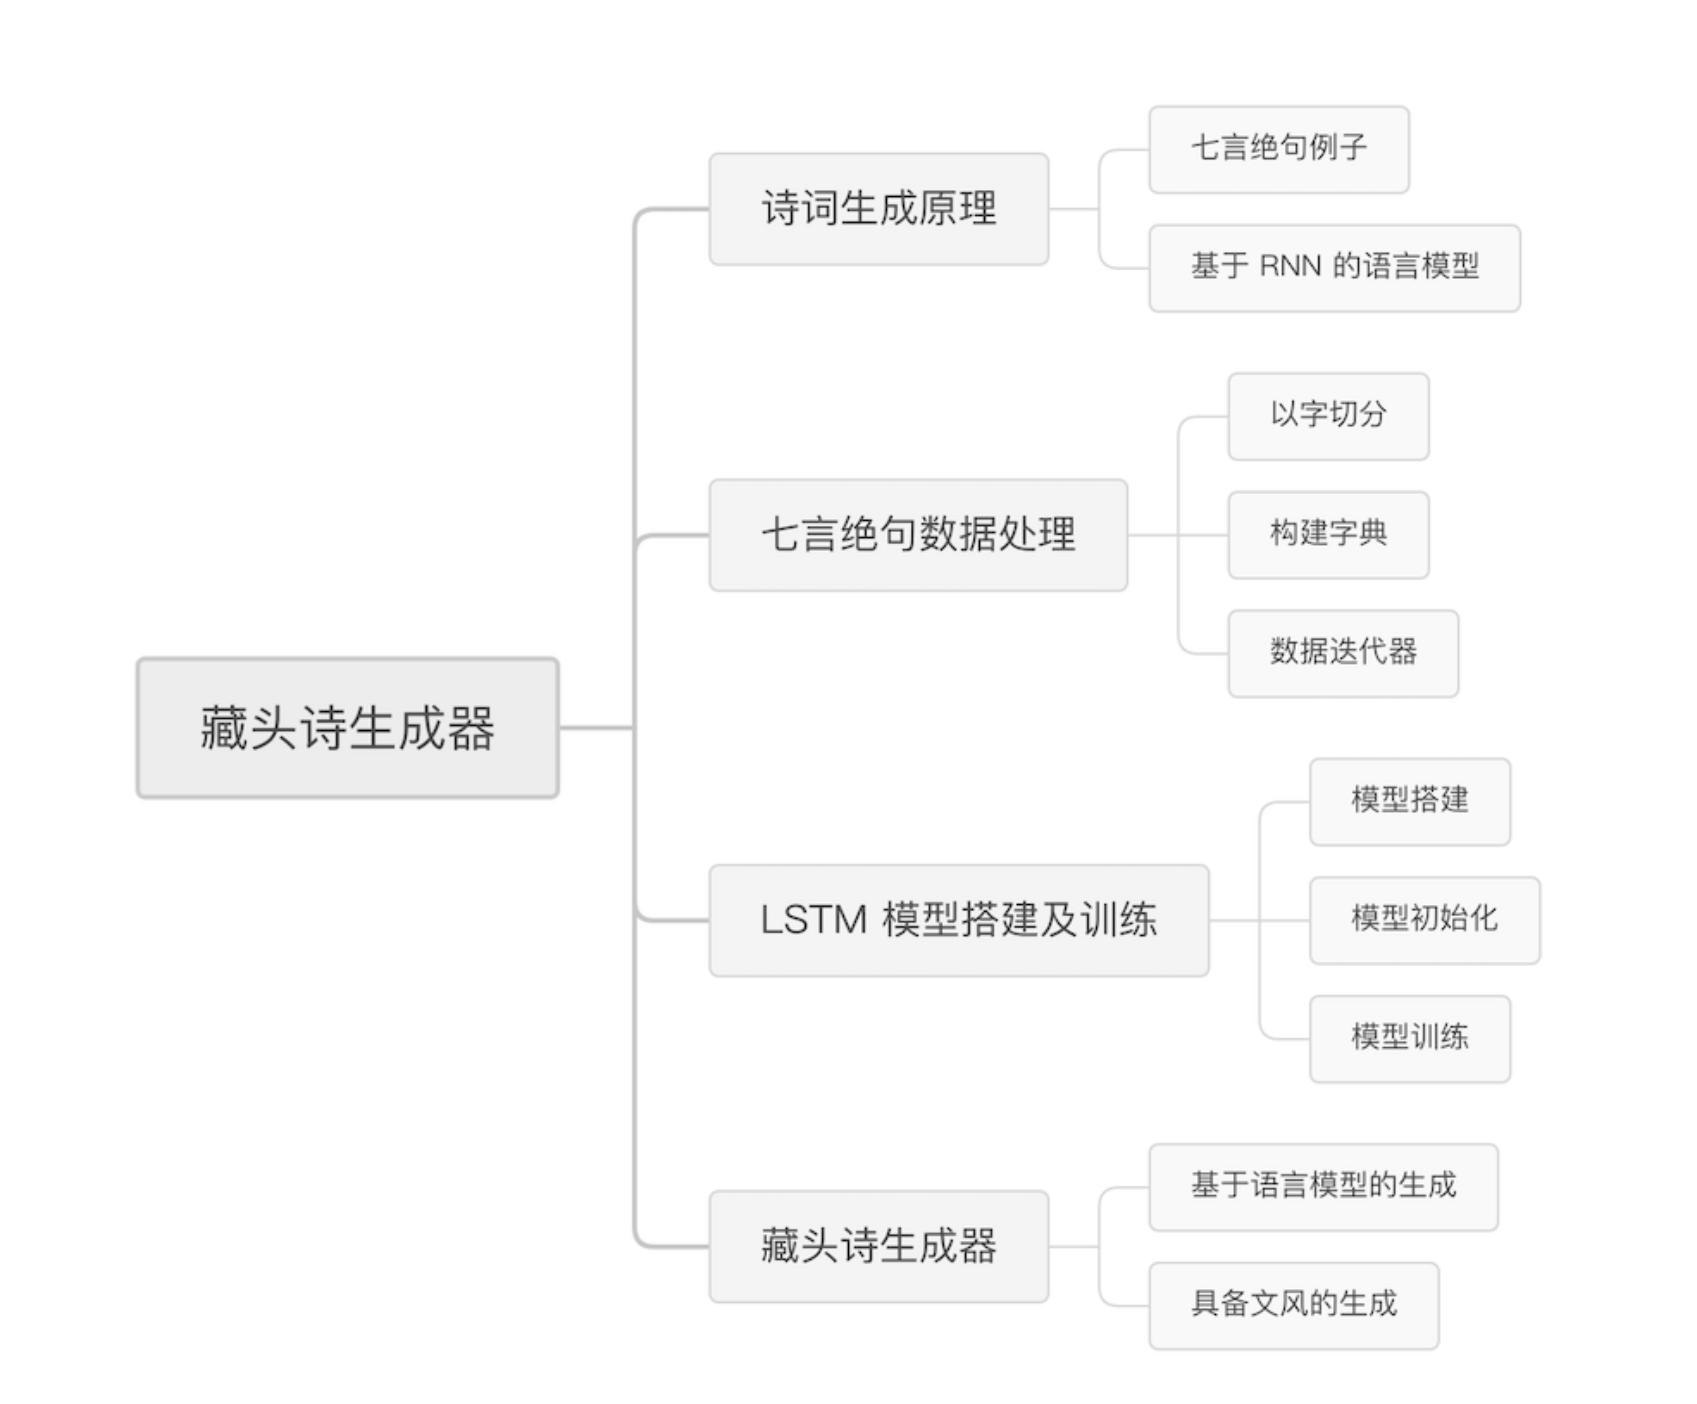

### 诗词生成原理

首先观察以下诗句，你觉得写得怎么样，有什么发现吗？

- '深宫娥向秦人间', '度江水辽天帝自', '学士大征鞍马嘶', '习气秪鬻不回首'
- '深坞帛头泷吏问', '度春水一望一相', '学养养子君一枝', '习不见一年一夜'

没错，这是两首“七言绝句”，藏头是“深度学习”，而且是本实验所训练的模型写出来的！是不是不仔细瞧还像模像样的呢！

这背后的原理，无非是基于循环神经网络训练一个语言模型，如何训练呢？我们只需要将诗句<font color=#0099ff>相隔一个词</font>分别作为网络的输入及输出，如下图所示：

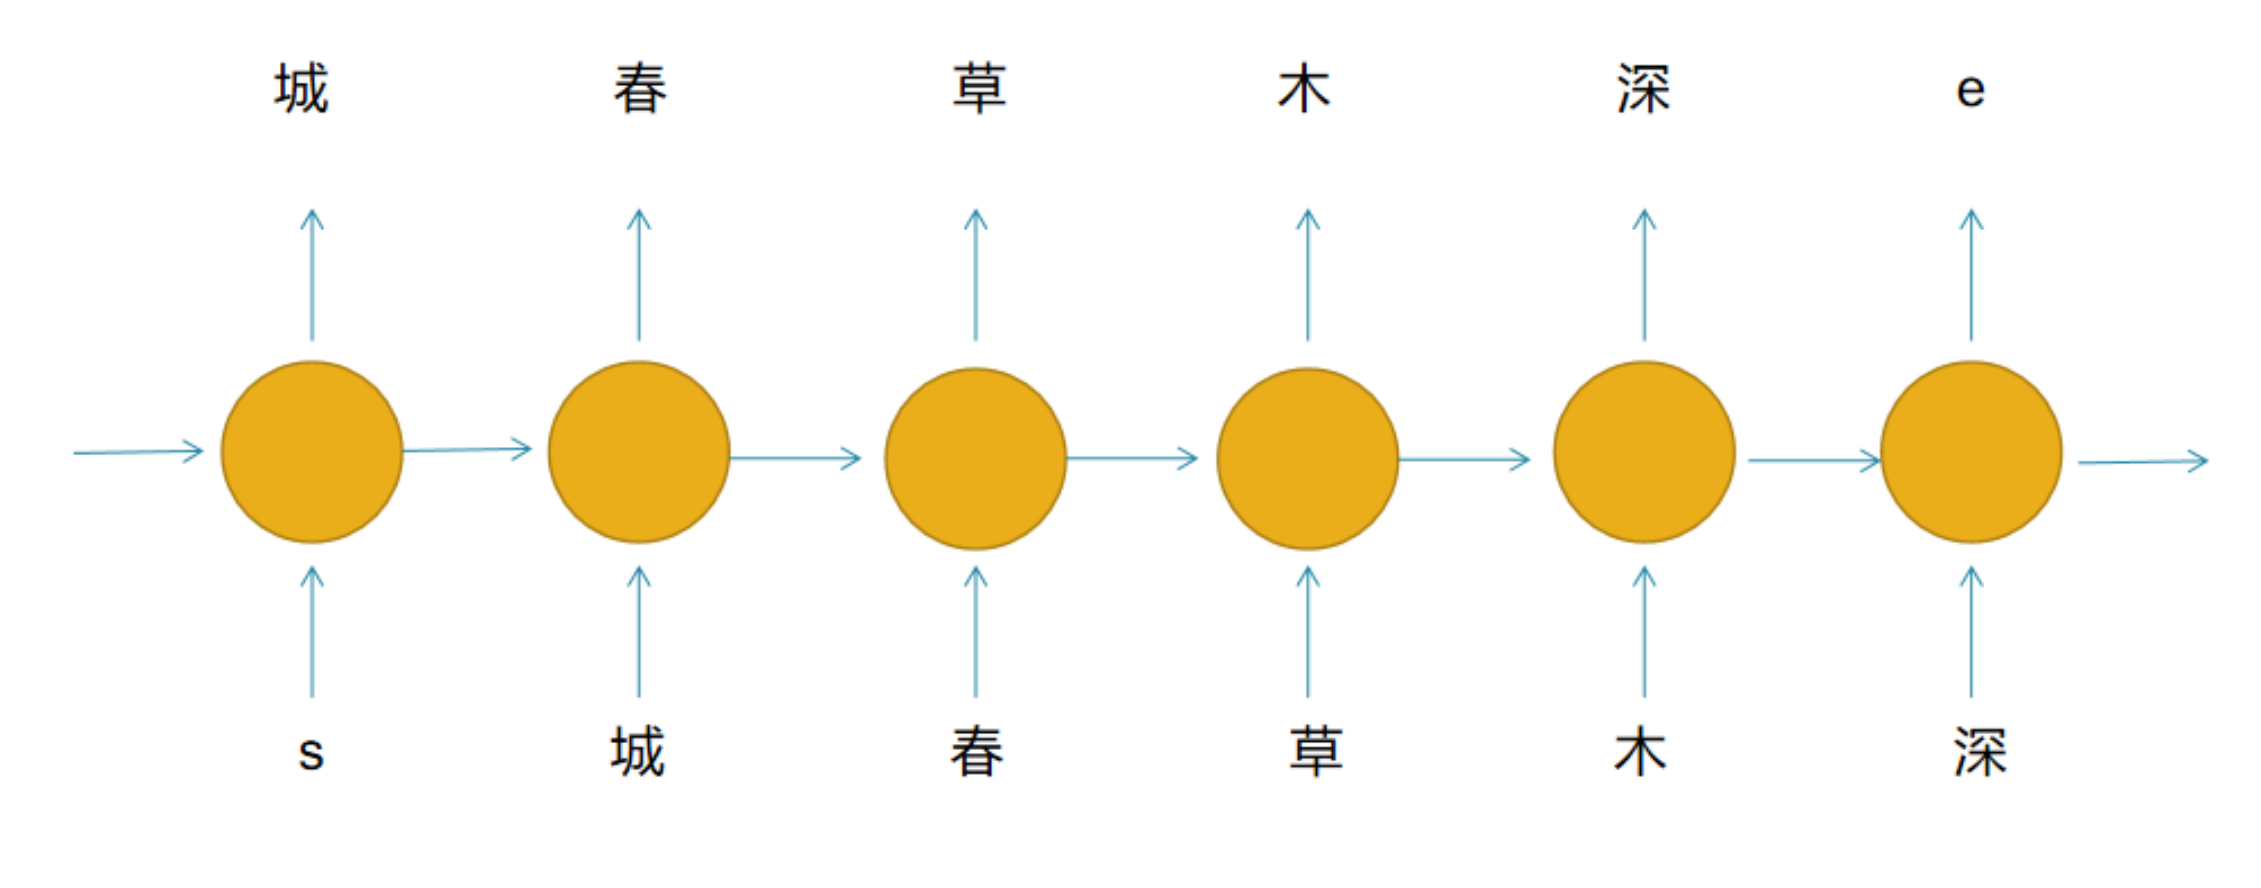

在上图中，黄圈代表一个循环神经网络单元，s 表示诗句的开头，e 表示诗句的结束符。由于循环神经网络的每一步都有输出，我们可以再接一层全连接，基于此预测下一个单词是什么，也就是做一个基于<font color=#0099ff>词典大小的分类</font>，而且是每一步都做分类（实际上称为序列标注任务）。对于模型而言，相当于给它看“s”，让它预测“城”，给它看“s城”，让它预测“春”，给它看“s城春”，让它预测“草”，以此类推，在经历大量语料训练之后，我们给定模型上文，其便可预测下文，这便是诗歌生成的基本原理。

### 七言绝句数据处理

古诗词中一般以字为词，因为对文本数据，统计其中的字构成字典：

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 教学代码：</i>

In [ ]:
from tqdm import tqdm

# 获取字典
def get_vocab(file_path):
    chars = []
    with open(file_path,"r",encoding="utf-8") as f: # 读取文件
        texts = f.readlines()
        for line in tqdm(texts): # 获取所有的字
            for char in line.strip():
                chars.append(char)
    return set(chars) # 去重

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 动手练习：</i>

查看字典量（此处以字为单位，因此字典大小不是非常大，不需要去除低频字）：

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3382/tang_poem_train.txt"
chars = get_vocab("tang_poem_train.txt")
len(chars)

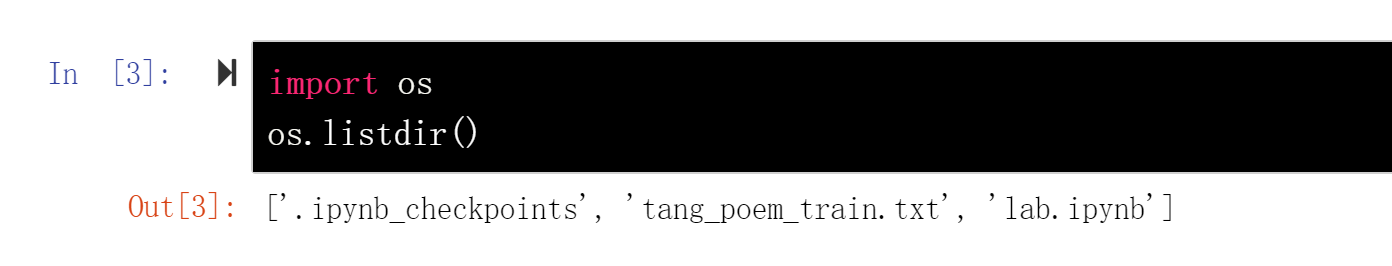

接下来构建字与 id 的对应表，因为字要转换为 id 才能输入模型，而模型预测出 id 的形式，在生成时需要重新转换为 id。

In [ ]:
# 构建字与 id 的双向对应字典
def create_char_id(vocab):
    char2id = {"s": 0, "e": 1, "u": 2}  # 　添加　"s"、"e" 以及 "u"，分别代表首字符、尾字符以及未登录字
    id2char = {0: "s", 1: "e", 2: "u"}
    for c in vocab:
        char2id[c] = len(char2id)
        id2char[len(id2char)] = c
    return char2id, id2char

In [ ]:
char2id, id2char = create_char_id(chars)

接下来读取数据，并且添加首尾符号和转化为 id 的形式，由于诗的长度统一，因此不需要 padding 操作。

In [ ]:
def load_dataset(file_path):
    datasets = []
    with open(file_path, "r", encoding="utf-8") as f:  # 读取数据
        lines = f.readlines()
    for line in tqdm(lines):  # 遍历数据
        line = line.strip()
        # 添加首尾符号
        line = "s" + line + "e"
        char_idx = [char2id.get(word, char2id.get("u")) for word in line]
        datasets.append(char_idx)
    return datasets

traindataset = load_dataset("tang_poem_train.txt")
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3382/tang_poem_valid.txt"
validdataset = load_dataset("tang_poem_valid.txt")

针对数据构建数据迭代器，注意在设计数据的输入输出时，假设诗句长度为 n，输入取前 n-1 个字符，输出取后 n-1 个字符。

In [2]:
import math
import torch

DEVICE = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")  # 如果有 GPU, 将数据与模型转换到 cuda

# 数据迭代器


class DatasetIterator:
    def __init__(self, dataset, batch_size):
        self.batch_size = batch_size  # 一批数据量的大小
        self.dataset = dataset
        self.n_batches = math.floor(len(dataset)/batch_size)  # 向下取整的批次大小
        self.num = len(dataset)  # 数据量大小
        self.residue = True  # 默认不可以取整
        if len(dataset) % self.batch_size == 0:  # 所有数据量是否能被批数据量整除
            self.residue = False
        self.index = 0

    def _to_tensor(self, datas):  # 将数据转换为 tensor，并且 copy 一份到 device 所指定的环境上
        # 输入输出相差一个字符
        x = torch.LongTensor([x[:len(x)-1] for x in datas]).to(DEVICE)
        y = torch.LongTensor([x[1:] for x in datas]).to(DEVICE)
        return x, y

    def __next__(self):  # 返回迭代器的下一个元素
        # 在不能取整的情况下，对于最后一批数据，需要额外分为一种情况
        if self.residue and self.index == self.n_batches:
            batch_data = self.dataset[self.index *
                                      self.batch_size:len(self.dataset)]
            self.index += 1
            batch_data = self._to_tensor(batch_data)
            return batch_data  # 返回一个 batch 的数据
        elif self.index >= self.n_batches:  # 当 index 超出范围时，停止迭代
            self.index = 0
            raise StopIteration
        else:  # 其它情况
            batch_data = self.dataset[self.index *
                                      self.batch_size:(self.index+1)*self.batch_size]
            self.index += 1
            batch_data = self._to_tensor(batch_data)
            return batch_data

    def __iter__(self):
        return self

    def __len__(self):  # 迭代器长度
        if self.residue:  # 如果不能取整，迭代器中的元素为向下取整的值 +1
            return self.n_batches + 1
        else:
            return self.n_batches

对训练及验证数据批次化处理：

In [ ]:
BATCH_SIZE = 60

train_iter = DatasetIterator(traindataset, BATCH_SIZE)
valid_iter = DatasetIterator(traindataset, BATCH_SIZE)

### LSTM 模型搭建及训练

接下来搭建 LSTM 模型，前后分别接词向量层和输出层：

In [ ]:
import torch.nn as nn


class PoetryModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers):
        super(PoetryModel, self).__init__()
        self.hidden_dim = hidden_dim  # 隐层大小
        self.num_layers = num_layers  # LSTM 层数
        self.embeddings = nn.Embedding(vocab_size, emb_dim)  # 词向量层
        self.lstm = nn.LSTM(emb_dim, self.hidden_dim, num_layers)  # LSTM 层
        self.fc = nn.Linear(self.hidden_dim, vocab_size)  # 输出层

    def forward(self, input, hidden=None, cell=None):
        seq_len, batch_size = input.size()  # 获取输入文本长度 seq_len 以及批次大小 batch_size
        # 初始化 hidden, cell
        if hidden is None:
            hidden = torch.zeros(self.num_layers, batch_size,
                                 self.hidden_dim).to(DEVICE)
        if cell is None:
            cell = torch.zeros(self.num_layers, batch_size,
                               self.hidden_dim).to(DEVICE)

        embeds = self.embeddings(input)
        # embeds = (seq_len,batch_size,embeding_dim)
        output, (hidden, cell) = self.lstm(embeds, (hidden, cell))
        # output = (seq_len,batch_size,hidden_dim)
        output = self.fc(output.view(seq_len*batch_size, -1))
        # output = (seq_len*batch_size,vocab_size)
        return output, hidden, cell

设置相关参数，模型及损失器初始化：

In [ ]:
# 相关参数
VOCAB_SIZE = len(char2id)
EMD_DIM = 256  # 词向量维度
HIDDEN_DIM = 512  # 隐层大小
N_LAYERS = 2  # LSTM 层数

# 模型及损失器初始化
poetry_model = PoetryModel(
    VOCAB_SIZE, EMD_DIM, HIDDEN_DIM, N_LAYERS).to(DEVICE)
criterion = nn.CrossEntropyLoss()
print(poetry_model)
print(criterion)

在以上过程中，定义了数据迭代器以及模型，接下来进行模型训练。首先定义训练函数：

In [ ]:
SEQ_LEN = 33  # 　加上首尾，七言绝句的固定长度为 33


def train(model, data_iter):
    model.train()
    train_loss = 0
    optimizer = torch.optim.Adam(model.parameters())  # 优化器

    for src_trg in data_iter:
        src, trg = src_trg[0].view(
            SEQ_LEN, -1), src_trg[1].view(SEQ_LEN, -1)  # 分别获取源语句，目标语句
        model.zero_grad()
        output, _, _ = model(src)  # 模型输出

        loss = criterion(output, trg.view(-1))  # 计算损失
        loss.backward()  # 损失回传
        optimizer.step()
        train_loss += loss.item()  # 损失叠加

    return train_loss / data_iter.num

定义测试函数：

In [ ]:
def test(model, data_iter):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for src_trg in data_iter:
            src, trg = src_trg[0].view(
                SEQ_LEN, -1), src_trg[1].view(SEQ_LEN, -1)  # 分别获取源语句，目标语句
            output, _, _ = model(src)  # 模型输出

            loss = criterion(output, trg.view(-1))  # 计算损失
            test_loss += loss.item()  # 损失叠加

    return test_loss / data_iter.num

设置随机种子，保证结果可复现：

In [3]:
# 保证每次结果一样
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

综合以上，对模型进行训练及训练过程可视化，并且保存最佳模型：

In [ ]:
import time

N_EPOCHS = 1
best_valid_loss = float('inf')

# 开始训练
for epoch in range(N_EPOCHS):
    start_time = time.time()  # 计时

    train_loss = train(poetry_model, train_iter)
    valid_loss = test(poetry_model, valid_iter)
    if valid_loss < best_valid_loss:  # 保存最好的模型
        best_valid_loss = valid_loss
        torch.save(poetry_model.state_dict(), 'poetry_model_cpu.pkl')

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    # 训练过程可视化
    print('Epoch: %d' % (epoch + 1),
          " | %d minutes, %d seconds" % (mins, secs))
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

由于在线环境运行较慢，上面只训练了 1 个 EPOCH （每个 EPOCH 大概 15 分钟）作为演示。

### 藏头诗生成器

在训练好语言模型之后，我们希望基于此构建一个藏头诗生成器，输入 4 个藏头，模型生成以这些字为开头的诗句，为了达到这个目的，只需要取语言模型所预测的概率最高的字即可。另一方面，我们还希望，诗词能够体现不一样的文风，可以将某些文风强烈的诗句 `prefix_words` 预先输出语言模型得到相应的 hidden,cell，再将其作为<font color=#0099ff>初始化的状态</font>输入语言模型生成藏头诗，之后所生成的诗句便可能带有 `prefix_words` 的风格。

In [ ]:
def gen_acrostic(model, start_chars, prefix_words=None):
    assert len(start_chars) == 4
    poem_len = 7

    input = torch.LongTensor([char2id["s"]]).view(1, 1).to(DEVICE)  # 首字为 s
    output, hidden, cell = model(input)
    # 将 prefix_words 输入语言模型，获取相关 hidden,cell
    if prefix_words:
        for word in prefix_words:
            output, hidden, cell = model(input, hidden, cell)
            input = torch.LongTensor([char2id[word]]).view(1, 1).to(DEVICE)

    res = []
    for char in start_chars:
        poem = char  # 初始化诗句
        input = torch.LongTensor([char2id[char]]).view(1, 1).to(DEVICE)  # 首字
        i = 0
        while i < poem_len-1:  # 七言诗
            output, hidden, cell = model(input, hidden, cell)
            # input  = output.argmax(1) # 取概率最高的 id
            input = torch.LongTensor([output.argmax(1)]).view(
                1, 1).to(DEVICE)  # 取概率最高的 id 作为下一次输入
            next_c = id2char[output.argmax(1).item()]  # 查表得到下一个字
            if next_c in ["，", "。", "？"]:
                continue
            i += 1
            poem += next_c
        res.append(poem)
    return res

载入模型：

In [ ]:
acrostic_model = PoetryModel(
    VOCAB_SIZE, EMD_DIM, HIDDEN_DIM, N_LAYERS).to(DEVICE)
acrostic_model.load_state_dict(torch.load("poetry_model_cpu.pkl"))

由于在线环境运行较慢，上面只训练了 1 个 EPOCH 作为演示。接下来，你可以下载我在本地训练了 30 个 EPOCH 的模型用于推理：

```python
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3382/poetry_model.pkl"
classifier.load_state_dict(torch.load("poetry_model.pkl",map_location=torch.device('cpu')))
```

In [ ]:
# 测试 1
prefix_words = "铁马冰河入梦来"
start_chars = "深度学习"
gen_acrostic(acrostic_model, start_chars, prefix_words)

替换前缀句，可生成不一样文风的诗句：

In [ ]:
# 测试 2
prefix_words = "杨柳青青江水平"
start_chars = "深度学习"
gen_acrostic(acrostic_model, start_chars, prefix_words)

### 实验总结

本实验基于 LSTM 神经网络模实现语言模型，并由此构建了一个藏头诗生成器，效果“看上去还不错”。事实上，在训练时我们喂给 LSTM 什么样的语料，在应用过程中就可以生成相应类型的文本，比如散文生成、新闻生成甚至小说生成。当然，这其中的前提是，必须要准备大量丰富的语料，让模型见得足够多，学习地足够多。另外，有条件地生成文本一直是语言生成中的一大难题，也是很多企业落地项目亟待解决的问题，有志于此的同学可以往这个方向做一些探究。

本实验的主要知识点如下：

- 诗词生成原理
- 七言绝句数据处理
- LSTM 模型搭建及训练
- 藏头诗生成器

在接下来的实验中，我们将学习 NLP 领域另一大重要的结构，注意力机制。